# Exploring the gemma model

Exploratory analyses by Casey Dunn, [https://dunnlab.org]. I am running these analyses locally on a Windows 11 machine with CUDA 11.8.

The goal is to take a look under the hood of the [Gemma](https://www.kaggle.com/models/google/gemma) model to better understand [transformers](https://arxiv.org/abs/1706.03762). In particular, I would like to have a practical understanding of the concepts explored in Grant Sanderson's series starting [here](https://youtu.be/wjZofJX0v4M?si=-Lsf1nH69cNyNVi3).

## Importing model weights

[Download](https://www.kaggle.com/models/google/gemma) the model weights for pytorch. This requires that you create a kaggle account, and you may need to request access to the model (approval can take a day or two). 

I used the  the 1.1-2b-it variation, and downloaded them as a as a `tar.gz` file. Decompress the file to get the `gemma-2b-it.ckpt` model weights file.

## Configuring your environment

Install the necessary packages

```bash
nvcc --version
conda create --name torch
conda activate torch
conda install pytorch torchvision torchaudio pytorch-cuda=11.8 immutabledict sentencepiece matplotlib -c pytorch -c nvidia -c conda-forge
```

## Loading the model


In [1]:
import torch

from gemma import config
from gemma import model as gemma_model
import random
import numpy as np
import contextlib

In [2]:
print(torch.__version__)
print(torch.cuda.is_available())

2.3.0
True


Using code from https://ai.google.dev/gemma/docs/pytorch_gemma/ to implement the Gemma model in PyTorch. Also drawing from https://github.com/google/gemma_pytorch/blob/main/scripts/run.py

In [3]:
# Choose variant and machine type
VARIANT = '2b' # also works for '2b-it'
MACHINE_TYPE = 'cuda'
CKPT_PATH="C:\\Users\\casey\\Downloads\\gemma-2b-it.ckpt"

In [4]:
model_config = config.get_model_config(VARIANT)
model_config.dtype = "float32" if MACHINE_TYPE == "cpu" else "float16"
model_config.quant = False

# Seed random.
seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [5]:
@contextlib.contextmanager
def set_default_tensor_type(dtype: torch.dtype):
    """Sets the default torch dtype to the given dtype."""
    torch.set_default_dtype(dtype)
    yield
    torch.set_default_dtype(torch.float)

device = torch.device(MACHINE_TYPE)
with set_default_tensor_type(model_config.get_dtype()):
    model = gemma_model.GemmaForCausalLM(model_config)
    model.load_weights(CKPT_PATH)
    model = model.to(device).eval()
print("Model loading done")

Model loading done


In [6]:
# summarize the structure of the model
print(model)

GemmaForCausalLM(
  (embedder): Embedding()
  (model): GemmaModel(
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaAttention(
          (qkv_proj): Linear()
          (o_proj): Linear()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear()
          (up_proj): Linear()
          (down_proj): Linear()
        )
        (input_layernorm): RMSNorm()
        (post_attention_layernorm): RMSNorm()
      )
    )
    (norm): RMSNorm()
  )
  (sampler): Sampler()
)


In [7]:
## Testing the model

In [8]:
prompt = "What are maxwell's equations?"
output_len = 200
result = model.generate(prompt, device, output_len=output_len)
print(result)



Maxwell's equations are a set of four equations that describe the relationship between electric and magnetic fields. They are:

$$\nabla \cdot E = \rho$$

$$\nabla \cdot B = 0$$

$$\nabla \times E = -\frac{\partial B}{\partial t}$$

$$\nabla \times B = J$$

Where:

- E is the electric field
- B is the magnetic field
- ρ is the charge density
- J is the current density

Maxwell's equations are essential for understanding many phenomena in electromagnetism, such as the behavior of electric charges and magnetic fields in electromagnetic waves.


## Exploring the tokenizer

The tokenizer converts the input text into a sequence of integers, each representing a token. Sometimes a token is a whole word, sometimes it is a subword. A fun look at tokenizers can be found at [https://youtu.be/eLDYPvc7DNA?si=WPcVyjdCQlMe5cU0].

In [9]:
# Access the tokenizer from the model
tokenizer = model.tokenizer

# Input string
input_string = "This is an example sentence."

# Tokenize the input string
tokens = tokenizer.encode(input_string)

# Print the resulting tokens
print(tokens)

[2, 1596, 603, 671, 3287, 13060, 235265]


In [10]:
for token in tokens:
  print(f"\t{token}\t{tokenizer.decode(token)}")

	2	
	1596	This
	603	 is
	671	 an
	3287	 example
	13060	 sentence
	235265	.


In [11]:
decoded = tokenizer.decode(tokens)
print(decoded)

This is an example sentence.


In [12]:
print(tokenizer.encode("is"))
print(tokenizer.encode(" is"))
print(tokenizer.encode("Is"))

[2, 502]
[2, 603]
[2, 2437]


In [13]:
def show_token_breaks(tokenizer, text):
	tokens = tokenizer.encode(text)
	tokens_text = list()
	for token in tokens:
		token_text = tokenizer.decode(token)
		tokens_text.append(token_text)
	return "|".join(tokens_text)

Rather than look at lists of token integers and text, we can just mark the breaks between the tokens in the text with `|`.

In [14]:
print(show_token_breaks(tokenizer, "This is an example sentence."))

|This| is| an| example| sentence|.


In [15]:
print(show_token_breaks(tokenizer, "The gastrozooids of siphonophores are a type of polyp."))

|The| gast|roz|oo|ids| of| siphon|ophores| are| a| type| of| polyp|.


In [16]:
print(show_token_breaks(tokenizer, "let x_squared = x * x;"))

|let| x|_|squared| =| x| *| x|;


In [17]:
print(show_token_breaks(tokenizer, "y=mx+b"))

|y|=|mx|+|b


## Exploring the embedder

The embedder provides a vector embedding of each token. These vectors are the input to the transformer of the llm. 

First, let's copy the embeddings out of the model. 

In [18]:
embeddings = model.embedder.weight.data

# Move embeddings to the desired device (optional)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embeddings = embeddings.to(device)

# Print the shape of the embeddings tensor
print(embeddings.shape)

torch.Size([256000, 2048])


We see that there are are 256000 unique tokens, each represented as a vector in $\mathbb{R}^2048$ (2048 dimensional space).

tensor([10.6172,  4.5742, 14.6875, 10.6172,  9.6953, 10.6016, 10.6172, 10.5625,
        10.6172, 10.6172, 10.6172, 10.6172, 10.6172, 10.6172, 10.6172, 10.6172,
        10.6172, 10.6172, 10.6172, 10.6172], device='cuda:0',
       dtype=torch.float16)


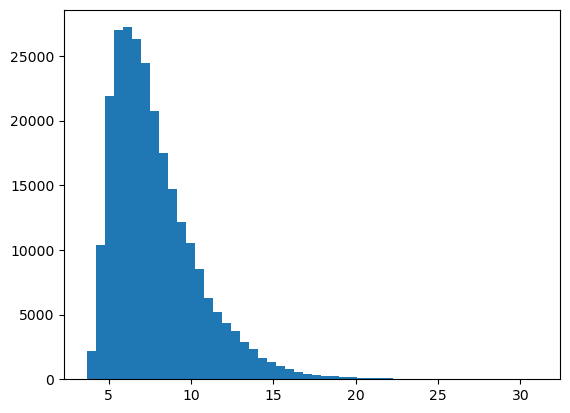

In [19]:
# Calculate the euclidean lengths of the embeddings
lengths = torch.linalg.norm(embeddings, ord=2, dim=1)
lengths.shape
print(lengths[0:20])

# Plot a histogram of the lengths
import matplotlib.pyplot as plt
plt.hist(lengths.cpu().numpy(), bins=50)
plt.show()

This is a histogram of the lengths of all the embeddings. We can see that the embeddings are not all the same lengths, ie they do not fall on a sphere in $\mathbb{R}^{2048}$. This means that embeddings differ by both the angle and the magnitude of the vector.

This means that the cosine distance and the euclidean distance between embeddings carry different (though of course related) information. So we will examine both.

In [20]:
def find_closest_tokens_by_embedding(embeddings, embedding, n=5, cosine=True):
	if cosine:
		# Calculate the cosine similarities to all other embeddings
		similarities = torch.nn.functional.cosine_similarity(embeddings, embedding.unsqueeze(0), dim=1)
		# Get the indices of the n largest similarities
		closest_tokens = torch.argsort(similarities, descending=True)[:n]
	else:
		# Calculate the euclidean distances to all other embeddings
		distances = torch.linalg.norm(embeddings - embedding, ord=2, dim=1)
		# Get the indices of the n smallest distances
		closest_tokens = torch.argsort(distances)[:n]
	return closest_tokens


# Function to find the n closest tokens to a given token based on euclidean distance in the embedding space
def find_closest_tokens(embeddings, token, n=5, cosine=True):
	# Get the embedding for the token
	embedding = embeddings[token]
	
	# Calculate the euclidean distances to all other embeddings
	closest_tokens = find_closest_tokens_by_embedding(embeddings, embedding, n, cosine)
	return closest_tokens

Let's look at the embeddings in the neighborhood of the token for `chicken`.

In [21]:
chicken_token = tokenizer.encode("chicken")[1]
print(chicken_token)

56863


First, here are the closest tokens according to cosine similarity.

In [22]:
# Find the 5 closest tokens to the chicken token
closest_tokens = find_closest_tokens(embeddings, chicken_token, n=20, cosine=True)
print(closest_tokens)

# Convert the tokens to text
closest_tokens_text = [tokenizer.decode(int(token)) for token in closest_tokens]
print(closest_tokens_text)

tensor([ 56863,  51788,  12254,  30501, 206247,  53190,  50883,  96636, 255634,
        252108, 252843, 255228, 255936, 253859, 254376, 254778, 254990, 255223,
        208296, 252367], device='cuda:0')
['chicken', 'Chicken', ' chicken', ' Chicken', ' CHICKEN', ' chickens', ' poultry', ' Poultry', '쑹', '꽈', '쟝', '힛', '먀', 'ᡴ', 'ᡨ', '괭', '꿩', '쑨', ' dieß', '돛']


Now we look at the closest tokens according to euclidean distance.

In [23]:
# Find the 5 closest tokens to the chicken token
closest_tokens = find_closest_tokens(embeddings, chicken_token, n=20, cosine=False)
print(closest_tokens)

# Convert the tokens to text
closest_tokens_text = [tokenizer.decode(int(token)) for token in closest_tokens]
print(closest_tokens_text)

tensor([ 56863,  51788,  30501,  12254,  53190,  50883,  42295,  37142,  52512,
         57044,  30701, 243808,  30038, 246077, 168617, 135716,  29828,  45962,
         46722,  32493], device='cuda:0')
['chicken', 'Chicken', ' Chicken', ' chicken', ' chickens', ' poultry', ' shrimp', ' turkey', ' 鸡', ' tuna', ' pork', '鸾', ' salmon', 'ｿ', '三個', '看了一眼', ' duck', ' seafood', 'pizza', ' tomato']


In [24]:
token2 = tokenizer.encode("house")[1]
print(token2)

6111


In [25]:
# Find the 5 closest tokens to the chicken token
closest_tokens = find_closest_tokens(embeddings, token2, n=20, cosine=True)
print(closest_tokens)

# Convert the tokens to text
closest_tokens_text = [tokenizer.decode(int(token)) for token in closest_tokens]
print(closest_tokens_text)

tensor([  6111,  64336,  19409,  32637,   3036,  38671,   4919,  12273,  54073,
         75745, 151808,   9285,  69959, 200531,  48960,  71471,  23470, 186719,
         25794,  83491], device='cuda:0')
['house', 'HOUSE', 'House', 'houses', ' house', ' HOUSE', ' House', ' houses', ' Houses', 'Haus', 'Houses', 'haus', 'housing', 'hous', 'huis', ' خانه', ' Haus', 'HAUS', 'thouse', 'ハウス']


In [26]:
# Find the 5 closest tokens to the chicken token
closest_tokens = find_closest_tokens(embeddings, token2, n=20, cosine=False)
print(closest_tokens)

# Convert the tokens to text
closest_tokens_text = [tokenizer.decode(int(token)) for token in closest_tokens]
print(closest_tokens_text)

tensor([  6111,  19409,   3036,   4919,  64336,  32637,  71471,  12273,  43916,
          7467,  38671,   9285,  83491,  63258, 101283,  82589, 110744,  59109,
         84648, 107723], device='cuda:0')
['house', 'House', ' house', ' House', 'HOUSE', 'houses', ' خانه', ' houses', ' дом', ' casa', ' HOUSE', 'haus', 'ハウス', '房子', ' ۶', ' ۴', ' ۷', ' ۳', ' ۵', ' ۸']


The cosine similarity might be a bit more interpretable than euclidean distance, and seems to be the norm in the field, so we will use that for now.

## Analogy engine

Each dimension in the embedding space can correspond to a different feature of the tokens. We can examine these relationships by subtracting the embeddings of two tokens, and applying that difference to another word. This is basically an analogy engine. For example, if we find the embedding of `king` - `man` + `woman`, we might get an embedding that is close to `queen`.

In [27]:
def analogy_by_tokens(embeddings, token_a, token_b, token_c, n=5):
	# Get the embeddings for the tokens
	embedding_a = embeddings[token_a]
	embedding_b = embeddings[token_b]
	embedding_c = embeddings[token_c]
	
	# Calculate the analogy vector
	analogy_vector = embedding_b - embedding_a + embedding_c
	
	# Calculate the euclidean distances to all other embeddings
	closest_tokens = find_closest_tokens_by_embedding(embeddings, analogy_vector, n)
	return closest_tokens

def analogy(embeddings, tokenizer, text_a, text_b, text_c, n=5):
	# Encode the text to tokens
	token_a = tokenizer.encode(text_a)[1]
	token_b = tokenizer.encode(text_b)[1]
	token_c = tokenizer.encode(text_c)[1]
	
	# Calculate the analogy
	closest_tokens = analogy_by_tokens(embeddings, token_a, token_b, token_c, n)
	
	# Convert the tokens to text
	closest_tokens_text = [tokenizer.decode(int(token)) for token in closest_tokens]

	return closest_tokens_text

def token_distance(embeddings, token_a, token_b):
	embedding_a = embeddings[token_a]
	embedding_b = embeddings[token_b]
	distance = torch.linalg.norm(embedding_a - embedding_b, ord=2)
	return distance

def text_distance(embeddings, tokenizer, text_a, text_b):
	token_a = tokenizer.encode(text_a)[1]
	token_b = tokenizer.encode(text_b)[1]
	distance = token_distance(embeddings, token_a, token_b)
	return distance

In [28]:
print(analogy(embeddings, tokenizer, "man", "king", "woman", 20))

['king', 'KING', 'woman', 'women', 'kings', '襞', ' KING', 'Ꮹ', 'ᘏ', '⻑', '╾', '籔', 'ᔪ', ' 跡', 'ſſed', 'Ꮅ', 'Ꮝ', 'Ꮣ', '໋', '梃']


In [29]:
print(analogy(embeddings, tokenizer, "man", "woman", "uncle", 20))

['uncle', ' uncle', '銛', 'ቺ', '⻑', 'ᘏ', '⾔', 'ژگی', '♺', ' 工房', 'ୂ', '龗', '苌', '⡌', ' 個室', 'ſons', '厠', 'Ꮿ', '褌', '黥']


In [30]:
print(analogy(embeddings, tokenizer, "finger", "hand", "petal", 20))

['petal', ' petal', ' HAND', ' petals', 'clover', 'floral', 'crane', ' ß', 'sandy', ' thal', ' Petal', ' Hs', ' ALPHA', ' Tg', 'ꦥ', 'ꦩ', ' ORD', ' lino', 'mosaic', ' dE']


In [31]:
print(analogy(embeddings, tokenizer, "fire", "burn", "flood", 20))

['flood', 'burn', 'Flood', ' Flood', 'BURN', ' flood', ' BURN', 'burns', 'Burn', ' FLOOD', '꯵', 'ꦮ', '쫑', '셍', ' Burn', '쥰', '헴', '쿰', '힛', '헉']


In [32]:
print(analogy(embeddings, tokenizer, "apple", "apples", "banana", 20))

['banana', 'Banana', ' Banana', 'apples', ' Bananas', 'whiskey', ' banana', ' bananas', 'popcorn', 'Bananas', ' resis', ' dissol', 'poop', 'mushroom', ' NUK', 'champagne', ' Lb', 'crab', ' SPAN', ' choco']


In [33]:
print(text_distance(embeddings, tokenizer, "man", "woman"))

tensor(2.5918, device='cuda:0', dtype=torch.float16)


On the whole, the analogy machine isn't great. It may be that without any sort of refinement from an attention mechanism, the raw embeddings are not so informative. King could mean a card, for example.

# Local neighborhoods

Above we just look at what tokens are nearby. Now let's look at the local neighborhood of a token in the embedding space. We will use PCA to reduce the dimensionality of the embeddings to 2D, and then plot the neighborhood of a token in this 2D space.

In [34]:
# Function that given a token and embeddings, finds the n closest tokens based on cosine similarity.
# It then returns a tuple with:
# - A vector where the first element is the original token and the rest are the closest tokens.
# - The subset of the embeddings corresponding to the tokens.
def find_closest_tokens_by_cosine(embeddings, token, n=5):
	# Get the embedding for the token
	embedding = embeddings[token]
	
	# Calculate the cosine similarities to all other embeddings
	similarities = torch.nn.functional.cosine_similarity(embeddings, embedding.unsqueeze(0), dim=1)
	
	# Get the indices of the n largest similarities
	closest_tokens = torch.argsort(similarities, descending=True)[:n]
	
	# Create a vector where the first element is the original token and the rest are the closest tokens
	closest_tokens_vector = torch.cat([torch.tensor([token]), closest_tokens])
	
	# Get the subset of the embeddings corresponding to the tokens
	closest_embeddings = embeddings[closest_tokens_vector]
	return closest_tokens_vector, closest_embeddings

# Function that given embeddings, runs a PCA on the embeddings and returns the first two principal components.
def run_pca(embeddings):
	# Calculate the mean of the embeddings
	mean = torch.mean(embeddings, dim=0)
	
	# Subtract the mean from the embeddings
	centered = embeddings - mean
	
	# Calculate the covariance matrix
	cov = torch.matmul(centered.T, centered)
	
	# Calculate the eigenvalues and eigenvectors of the covariance matrix
	eigenvalues, eigenvectors = torch.linalg.eig(cov)
	
	# Get the indices of the eigenvalues sorted in descending order
	indices = torch.argsort(eigenvalues[:, 0], descending=True)
	
	# Get the first two principal components
	pc1 = eigenvectors[:, indices[0]]
	pc2 = eigenvectors[:, indices[1]]
	
	return pc1, pc2

# Function that given a token and embeddings, runs find_closest_tokens_by_cosine() and run_pca() and plots the results.
# tokens are converted to text using the tokenizer and added to the plot.
def plot_closest_tokens_by_cosine(embeddings, tokenizer, token, n=5):
	# Find the closest tokens by cosine similarity
	closest_tokens_vector, closest_embeddings = find_closest_tokens_by_cosine(embeddings, token, n)
	
	# Run PCA on the embeddings
	pc1, pc2 = run_pca(closest_embeddings)
	
	# Create a scatter plot of the embeddings
	plt.figure(figsize=(10, 10))
	plt.scatter(closest_embeddings[:, 0], closest_embeddings[:, 1])
	
	# Add the token text to the plot
	for i, token in enumerate(closest_tokens_vector):
		text = tokenizer.decode(int(token))
		plt.text(closest_embeddings[i, 0], closest_embeddings[i, 1], text)
	
	# Add the principal components to the plot
	plt.arrow(0, 0, pc1[0], pc1[1], color='r', width=0.01)
	plt.arrow(0, 0, pc2[0], pc2[1], color='g', width=0.01)
	
	plt.xlabel('Principal Component 1')
	plt.ylabel('Principal Component 2')
	plt.title('Closest Tokens by Cosine Similarity')
	plt.show()


Todo....

## Playground

A few incomeplete ideas.

### infinite crafter

Try to make something like https://neal.fun/infinite-craft/

In [35]:
def craft_combine_substances(substance_a, substance_b):
	prompt = f"In one word describe the substance I get when I mix {substance_a} with {substance_b}."
	output_len = 20
	result = model.generate(prompt, device, output_len=output_len)
	return result

In [36]:
print(craft_combine_substances("fire", "dirt"))




**Answer:** Ashes.

Fire and dirt react to form ashes, which are a mixture of
